In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import gamma, norm
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy.interpolate import griddata
from shapely.geometry import Polygon, Point

In [ ]:
def func(file_path, SPI_Type = 1, start_date = "Oct-2021", end_date = "Oct-2021"):
    """
    Compute Standardized Precipitation Index (SPI) over a specified time period.

    Parameters:
    - file_path (str): Path to the CSV file containing precipitation data.
    - SPI_Type (int, optional): The time scale (in months) for SPI calculation. Defaults to 1.
    - start_date (str, optional): Start date of the period for SPI calculation in "Month-Year" format. Defaults to "Oct-2021".
    - end_date (str, optional): End date of the period for SPI calculation in "Month-Year" format. Defaults to "Oct-2021".

    Returns:
    - average_spi (float): Average SPI value computed over the specified period.
    - spi_df (DataFrame): DataFrame containing the SPI values computed over time.
    - frequency_drought (int): Frequency of drought occurrences (number of months with negative SPI values).

    Notes:
    - SPI_Type should be an integer value less than or equal to 12.
    - The start_date and end_date should be in the "Month-Year" format, e.g., "Oct-2021".
    - The CSV file at file_path should contain precipitation data with a 'Dates' column and rainfall values.
    - This function plots the SPI values over time and highlights positive SPI values in light blue,
      negative SPI values in orange, and the longest drought period in red.
    """
    def preprocess_data(data):
        data = data[np.isfinite(data)]
        data[data == 0] = 1e-15
        return data

    def compute_gamma_parameters(data):
        shape, loc, scale = gamma.fit(data, floc=0)
        return shape, scale

    def compute_SPI(precipitation, shape, scale):
        cdf = gamma.cdf(precipitation, shape, loc=0, scale=scale)
        spi = norm.ppf(cdf) 
        return spi

    df = pd.read_csv(file_path)
    rainfall_data = df.iloc[:, 1].values
    dates = df['Dates'].values
    rainfall_data = np.convolve(rainfall_data, np.ones(SPI_Type)/SPI_Type, mode='valid')
    if(SPI_Type <= 12):
        processed_data = preprocess_data(rainfall_data)
        shape, scale = compute_gamma_parameters(processed_data)
        spi_values = compute_SPI(processed_data, shape, scale)
        start_index , end_index = np.where(dates == start_date)[0][0], np.where(dates == end_date)[0][0]
        start_index , end_index = start_index - (SPI_Type-1), end_index - (SPI_Type-1)
        spi_range = spi_values[start_index:end_index + 1]
        mask = (spi_range < 0)
        frequency_drought = np.sum(mask)
        average_spi = np.mean(spi_range)
        print(f'Average SPI value from {start_date} to {end_date}: {average_spi:.2f}')
        spi_df = pd.DataFrame({'Date': dates[(SPI_Type-1):], 'SPI': spi_values})
        spi_df['Sign'] = ['Positive' if spi > 0 else 'Negative' for spi in spi_df['SPI']]
        plt.figure(figsize=(10, 6))
        plt.fill_between(spi_df['Date'], spi_df['SPI'], where=(spi_df['Sign'] == 'Positive'), color='lightblue', alpha=0.5, label='Positive SPI')
        plt.fill_between(spi_df['Date'], spi_df['SPI'], where=(spi_df['Sign'] == 'Negative'), color='orange', alpha=0.5, label='Negative SPI')
        # Find the longest drought period
        longest_neg_range = 0
        current_neg_range = 0
        start_index = None
        for i, val in enumerate(spi_df['SPI']):
            if val < 0:
                current_neg_range += 1
                if current_neg_range > longest_neg_range:
                    longest_neg_range = current_neg_range
                    start_index = i - current_neg_range + 1
            else:
                current_neg_range = 0
        if start_index is not None:
            plt.fill_between(spi_df['Date'].iloc[start_index:start_index + longest_neg_range],
                             spi_df['SPI'].iloc[start_index:start_index + longest_neg_range],
                             color='red', alpha=0.3, label='Drought Period')
            start_date_longest_range = spi_df['Date'].iloc[start_index]
            end_date_longest_range = spi_df['Date'].iloc[start_index + longest_neg_range - 1]
            print(f"Drought Period: {start_date_longest_range} to {end_date_longest_range}")
        plt.plot(spi_df['Date'], spi_df['SPI'], color='black', label='SPI Line',linestyle='-', linewidth=1)
        plt.xlabel('Dates')
        plt.ylabel('SPI Values')
        plt.title('SPI Over Time')
        plt.xticks(rotation=45)
        plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
        plt.legend()
        plt.tight_layout()
        plt.show()
        return average_spi, spi_df, frequency_drought
    else:
        print("Invalid SPI Type")
        return None, None, None

In [ ]:
def format_date(start_month, start_year, end_month, end_year):
    """
    Format the input start and end months/years into 'Month-Year' format (e.g., 'Jan-2016').
    """
    month_mapping = {
        1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr',
        5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
        9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
    }
    start_date = f"{month_mapping[start_month]}-{start_year}"
    end_date = f"{month_mapping[end_month]}-{end_year}"
    return start_date, end_date

start_month = int(input("Enter start month (1-12): "))
start_year = int(input("Enter start year: "))
end_month = int(input("Enter end month (1-12): "))
end_year = int(input("Enter end year: "))
start_date, end_date = format_date(start_month, start_year, end_month, end_year)
print(f"Formatted start date: {start_date}")
print(f"Formatted end date: {end_date}")
SPI_Type = int(input("Enter the SPI Type: "))

In [20]:
import os
import pandas as pd

latitudes = []
longitudes = []
station_names = []
average_spi_values = []
drought_frequencies = []

# Drought frequency is the count of months in the specified time period where the SPI value was negative
def process_csv_files(directory, SPI_Type, start_date, end_date, filename_lat_lon):
    average_spi_values = []
    drought_frequencies = []
    filenames = sorted(os.listdir(directory))
    
    for filename in filenames:
        if filename.endswith(".csv"):
            print(f"Processing file: {filename}")
            file_path = os.path.join(directory, filename)
            
            # Assuming func processes the CSV file and returns necessary values
            average_spi, spi_df, frequency_drought = func(file_path, SPI_Type=SPI_Type, start_date=start_date, end_date=end_date)
            average_spi_values.append(average_spi)
            drought_frequencies.append(frequency_drought)
            
            if filename in filename_lat_lon:
                lat, lon = filename_lat_lon[filename]
                latitudes.append(lat)
                longitudes.append(lon)
                
                # Add the station name by removing ".csv" from the filename
                station_name = filename.replace(".csv", "")
                station_names.append(station_name)

    return average_spi_values, drought_frequencies

# Dictionary with filenames and lat-lon values
filename_lat_lon = {
    "Gopurajapuram.csv": (10.8514, 79.8000),
    "Porakudi.csv": (10.9039, 79.7072),
    "Thengudi.csv": (10.9167, 79.6389),
    "Peralam.csv": (10.9663, 79.6612),
    "Annavasal.csv": (10.9750, 79.7537),
    "Grand Anicut.csv": (10.8300, 78.8100),
    "MUSIRI.csv": (10.9350, 78.4350),
    "NALLAMARANPATTY.csv": (10.8808, 77.9847),
    "ELUNUTHIMANGALAM.csv": (11.0317, 77.8875),
    "KODUMUDI.csv": (11.0811, 77.8903),
    "URACHIKOTTAI.csv": (11.4778, 77.7000),
    "THEVUR.csv": (11.5272, 77.7508),
    "SAVANDAPUR.csv": (11.5214, 77.5100),
    "Mettur Dam.csv": (11.8000, 77.8000),
    "THOPPUR.csv": (11.9383, 78.0572),
    "BILIGUNDULU.csv": (12.1822, 77.7239),
    "KUDLUR.csv": (11.8406, 77.4628),
    "Bhavanisagar Dam.csv": (11.4700, 77.1017),
    "THENGUMARAHADA.csv": (11.5728, 76.9192),
    "T. NARASIPUR.csv": (12.2300, 76.8917),
    "Kabini Dam.csv": (11.8417, 76.3381),
    "MUTHANKERA.csv": (11.8083, 76.0839),
    "T.K.HALLI.csv": (12.4167, 77.1925),
    "K.M. VADI.csv": (12.3461, 76.2878),
    "AKKIHEBBAL.csv": (12.6028, 76.4008),
    "KUDIGE.csv": (12.5025, 75.9611),
    "Harangi Dam.csv": (12.4917, 75.9056),
    "M.H. HALLI.csv": (12.8189, 76.1333),
    "SAKLESHPUR.csv": (12.9436, 75.7936),
    "Vazhavachanur.csv": (12.0658, 78.9781),
    "Avarankuppam.csv": (12.6842, 78.5394),
    "T. BEKKUPE.csv": (13.5172, 77.4369),
    "KELLODU.csv": (13.7500, 76.3456),
    "YENNEHOLE.csv": (13.2942, 74.9806),
    "PERUMANNU.csv": (11.9808, 75.5778),
    "AMBARAMPALAYAM.csv": (10.6314, 76.9461),
    "VAIGAI DAM.csv": (10.0761, 77.6683)
}

# Process the CSV files
average_spi_values, drought_frequencies = process_csv_files('hydroData', SPI_Type, start_date, end_date, filename_lat_lon)

# Output the results
print(latitudes)
print(longitudes)
print(station_names)
print(average_spi_values)
print(drought_frequencies)

# Create a DataFrame with latitudes, longitudes, station names, average_spi_values, and drought_frequencies
data = {
    'Station_Name': station_names,
    'Latitude': latitudes,
    'Longitude': longitudes,
    'Average_SPI': average_spi_values,
    'Drought_Frequency': drought_frequencies
}

# Convert the data into a DataFrame
df = pd.DataFrame(data)

# Export the DataFrame to a CSV file
output_csv_path = 'average_spi_values.csv'  # Change this to the desired output path
df.to_csv(output_csv_path, index=False)

print(f"Average SPI values exported to {output_csv_path}")


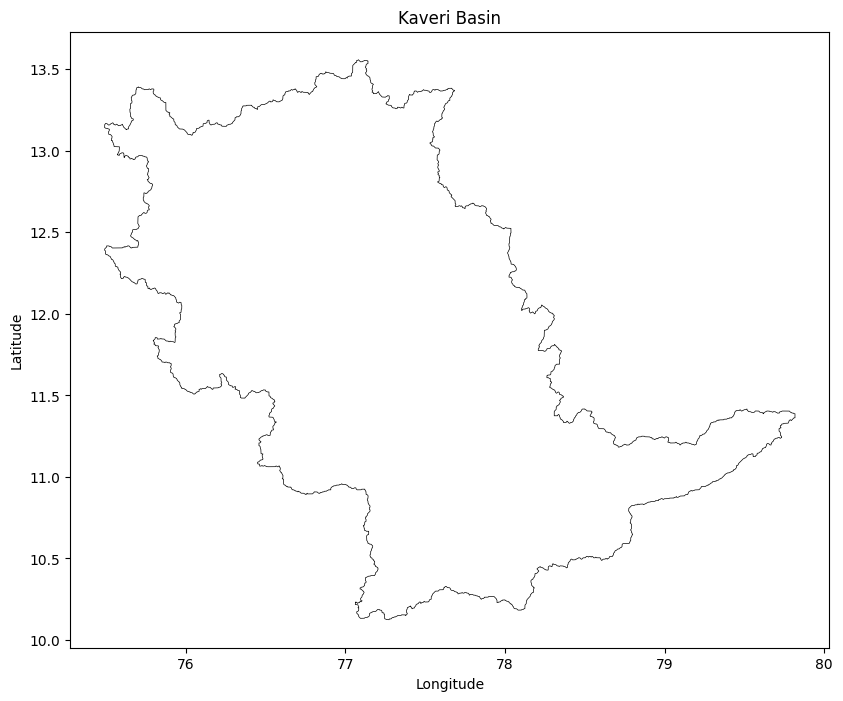

In [35]:
import shapefile
mahanadi_basin = gpd.read_file('./shapefile/kaveri.shp')
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_facecolor('white')
mahanadi_basin  .plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5)
plt.title('Kaveri Basin')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [36]:
import geopandas as gpd
mahanadi_basin = gpd.read_file('./shapefile/kaveri.shp')

# Print coordinates of each geometry in the shapefile
for geometry in mahanadi_basin['geometry']:
    print(geometry)


POLYGON ((78.22083333333336 12.03750000000002, 78.22414906819664 12.038350931803418, 78.22556728786894 12.043877156575553, 78.22859937879777 12.047789510091178, 78.22916666666669 12.054166666666685, 78.23137715657555 12.053599378797774, 78.23945617675784 12.046400621202288, 78.24387715657555 12.045266045464441, 78.2561228434245 12.033900621202289, 78.26191711425784 12.032413567437098, 78.27026604546444 12.023043823242219, 78.27175309922963 12.017249552408886, 78.2811228434245 12.008900621202288, 78.28554382324221 12.007766045464441, 78.28945617675784 12.004733954535622, 78.29911261664499 12.003458150227896, 78.30096774631079 11.996229214138486, 78.3061228434245 11.992233954535621, 78.30833333333335 11.991666666666697, 78.30771569146053 11.985339864095083, 78.30354902479387 11.97963578965932, 78.30478430853952 11.97700653076175, 78.30895097520619 11.971302456325986, 78.30771569146053 11.96450653076175, 78.29645097520618 11.952160135904979, 78.29521569146053 11.943673197428417, 78.292284

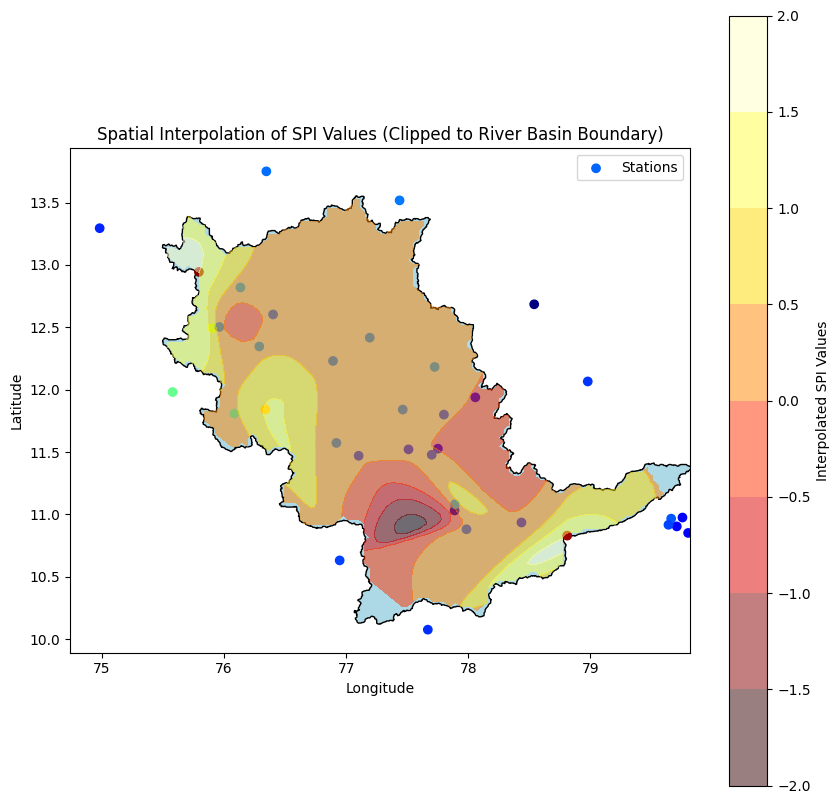

In [37]:
drought_frequencies = np.array(drought_frequencies, dtype=float)
river_basin = gpd.read_file('shapefile/kaveri.shp')
station_data = {
    'Frequency': drought_frequencies,
    'SPI': average_spi_values,
    'Longitude': longitudes,
    'Latitude': latitudes,
}
# 3. Plot the river basin
fig, ax = plt.subplots(figsize=(10, 10))
river_basin.plot(ax=ax, color='lightblue', edgecolor='black')

# 4. Plot the stations
ax.scatter(station_data['Longitude'], station_data['Latitude'], c=station_data['SPI'], cmap='jet', label='Stations')
# plt.colorbar(ax.scatter([], [], c=[], cmap='jet', label='SPI'), ax=ax, label='SPI Values')

# 5. Interpolate SPI values
# Define the grid over which to interpolate SPI values
x_grid = np.linspace(river_basin.bounds.minx.min(), river_basin.bounds.maxx.max(), 100)
y_grid = np.linspace(river_basin.bounds.miny.min(), river_basin.bounds.maxy.max(), 100)
X, Y = np.meshgrid(x_grid, y_grid)

# Interpolate SPI values using griddata
SPI_interpolated = griddata((station_data['Longitude'], station_data['Latitude']), 
                            station_data['SPI'], (X, Y), method='cubic')

# boundary_polygon = Polygon(river_basin.geometry.iloc[0].exterior)

# # Mask the interpolated SPI values outside the boundary
boundary_polygon = Polygon(river_basin.geometry.iloc[0].exterior)

# Clip the interpolated SPI values outside the boundary (brute force)
clipped_SPI = SPI_interpolated.copy()
for i in range(clipped_SPI.shape[0]):
    for j in range(clipped_SPI.shape[1]):
        point = Point(X[i, j], Y[i, j])
        if not boundary_polygon.contains(point):
            clipped_SPI[i, j] = np.nan

contour = plt.contourf(X, Y, clipped_SPI, cmap='hot', alpha=0.5)
plt.colorbar(contour, ax=ax, label='Interpolated SPI Values')
plt.title('Spatial Interpolation of SPI Values (Clipped to River Basin Boundary)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

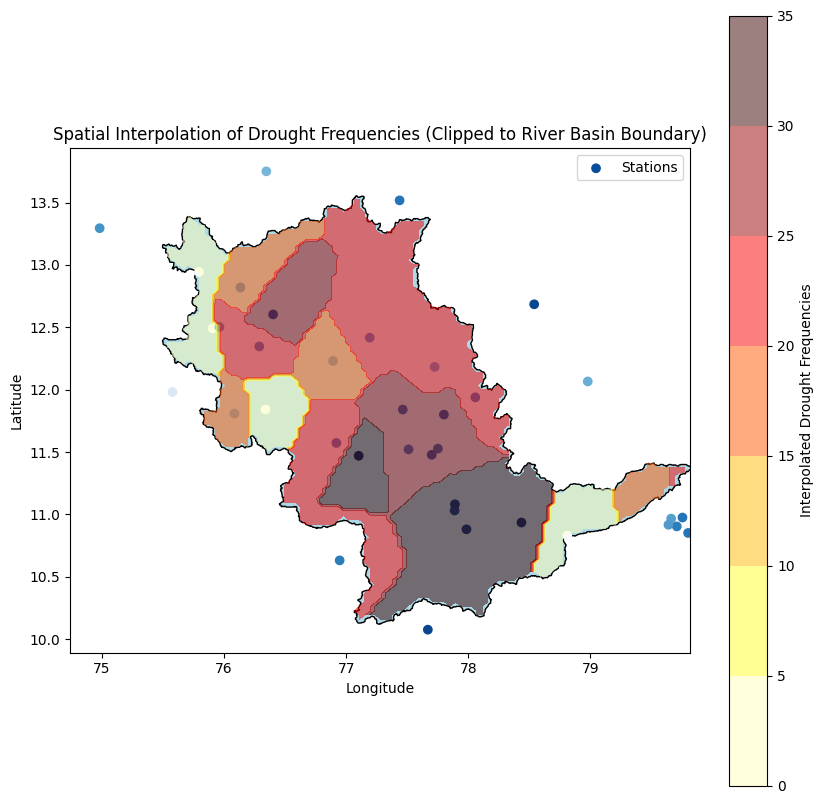

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))
river_basin.plot(ax=ax, color='lightblue', edgecolor='black')

# 4. Plot the stations
ax.scatter(station_data['Longitude'], station_data['Latitude'], c=station_data['Frequency'], cmap='Blues', label='Stations')
# plt.colorbar(ax.scatter([], [], c=[], cmap='jet', label='SPI'), ax=ax, label='SPI Values')

# 5. Interpolate SPI values
# Define the grid over which to interpolate SPI values
x_grid = np.linspace(river_basin.bounds.minx.min(), river_basin.bounds.maxx.max(), 100)
y_grid = np.linspace(river_basin.bounds.miny.min(), river_basin.bounds.maxy.max(), 100)
X, Y = np.meshgrid(x_grid, y_grid)

# Interpolate SPI values using griddata
Freq_interpolated = griddata((station_data['Longitude'], station_data['Latitude']), 
                            station_data['Frequency'], (X, Y), method='nearest')

# boundary_polygon = Polygon(river_basin.geometry.iloc[0].exterior)

# # Mask the interpolated SPI values outside the boundary
boundary_polygon = Polygon(river_basin.geometry.iloc[0].exterior)

# Clip the interpolated SPI values outside the boundary (brute force)
clipped_Freq = Freq_interpolated.copy()
for i in range(clipped_Freq.shape[0]):
    for j in range(clipped_Freq.shape[1]):
        point = Point(X[i, j], Y[i, j])
        if not boundary_polygon.contains(point):
            clipped_Freq[i, j] = np.nan

# Plot the clipped interpolated SPI values as a contour plot
contour = plt.contourf(X, Y, clipped_Freq, cmap='hot_r', alpha=0.5)
plt.colorbar(contour, ax=ax, label='Interpolated Drought Frequencies')

plt.title('Spatial Interpolation of Drought Frequencies (Clipped to River Basin Boundary)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

In [39]:
cnt = 0
dro = 0
for i in range(clipped_SPI.shape[0]):
    for j in range(clipped_SPI.shape[1]):
        if (np.isnan(clipped_SPI[i][j])) == False:
            cnt += 1
            if(clipped_SPI[i][j] < 0):
                dro += 1
print("Percentage of areal extent of drought: ", (dro/cnt)*100)

Percentage of areal extent of drought:  18.346870520783565


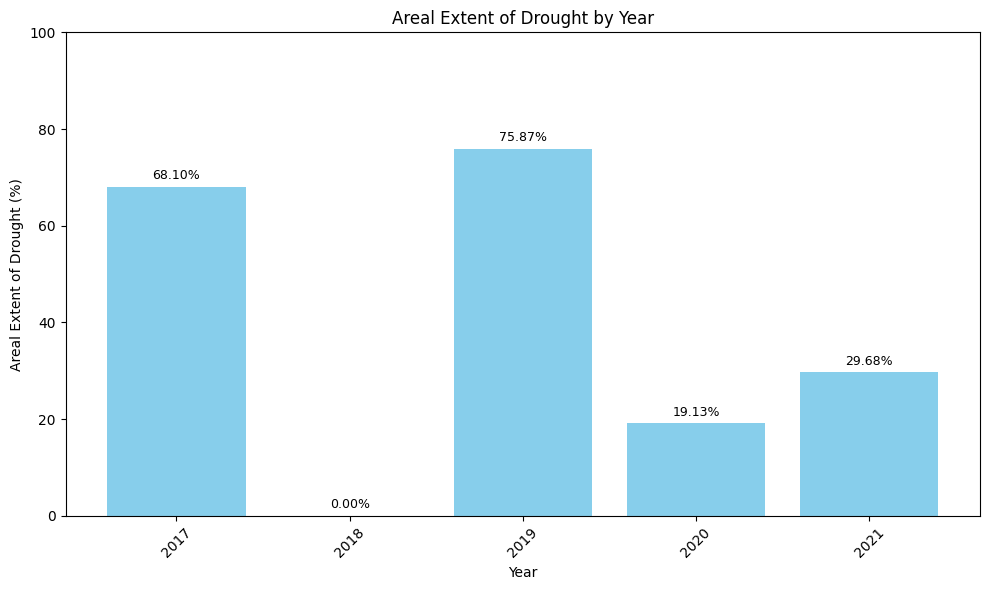

In [40]:
years = ['2017', '2018', '2019', '2020', '2021']
areal_extent = [68.09712586719525, 0.0, 75.86719524281466, 19.127849355797817, 29.682854311199208 ]

plt.figure(figsize=(10, 6))
plt.bar(years, areal_extent, color='skyblue')
plt.xlabel('Year')
plt.ylabel('Areal Extent of Drought (%)')
plt.title('Areal Extent of Drought by Year')
plt.xticks(rotation=45)
plt.ylim(0, 100)  # Set y-axis limit from 0 to 100
for i, val in enumerate(areal_extent):
    plt.text(i, val + 1, f'{val:.2f}%', ha='center', va='bottom', fontsize=9)  # Add text labels
plt.tight_layout()
plt.show()

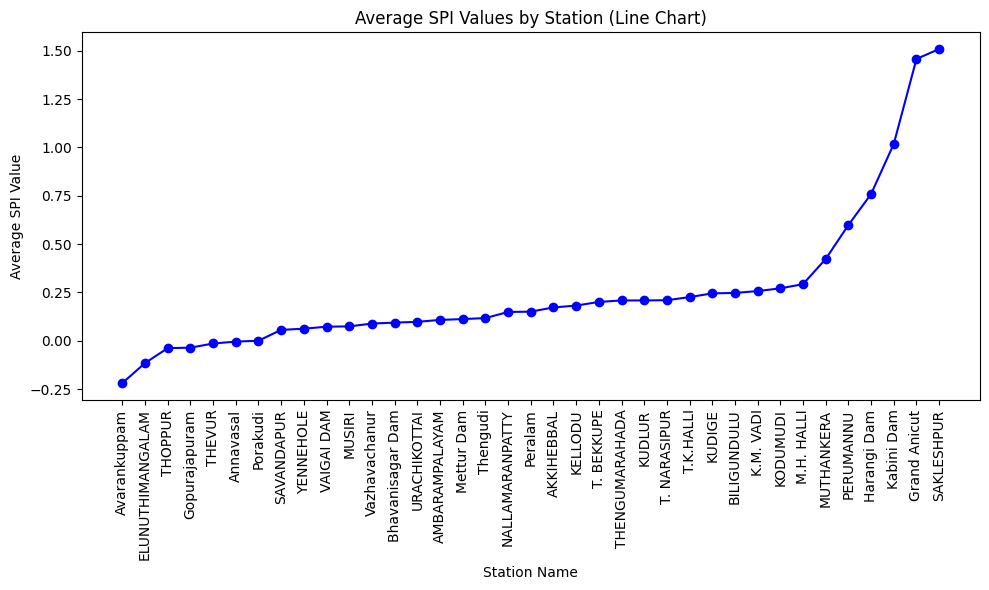

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('average_spi_values.csv')

# Ensure Station names are sorted (optional, based on your preference)
df = df.sort_values(by='Average_SPI')

# 1. Line Chart: SPI vs Station Name
plt.figure(figsize=(10, 6))
plt.plot(df['Station_Name'], df['Average_SPI'], marker='o', linestyle='-', color='b')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('Station Name')
plt.ylabel('Average SPI Value')
plt.title('Average SPI Values by Station (Line Chart)')
plt.tight_layout()
plt.show()



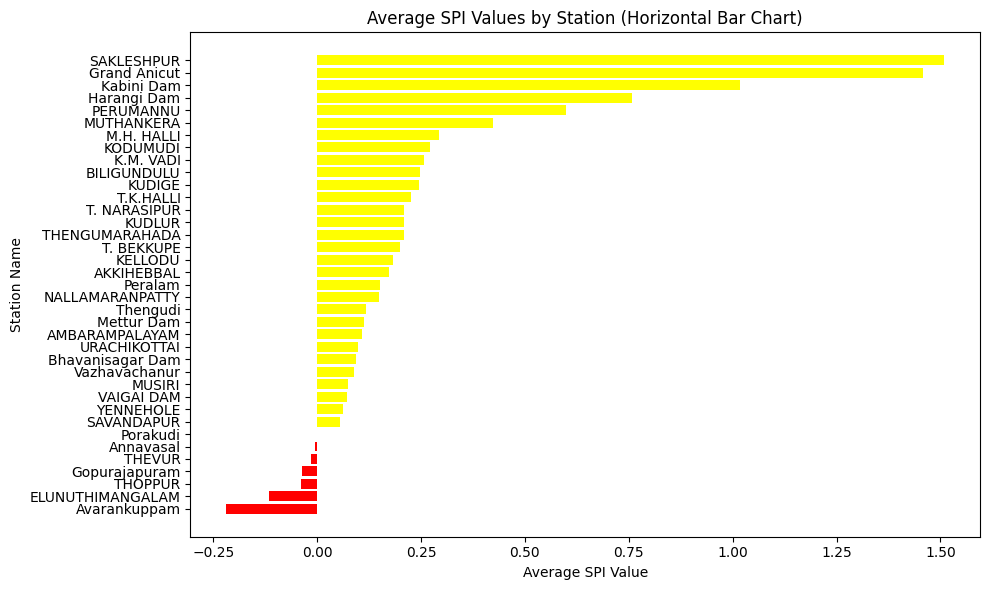

In [40]:
# # 2. Horizontal Bar Chart: SPI vs Station Name
# plt.figure(figsize=(10, 6))
# plt.barh(df['Station_Name'], df['Average_SPI'], color='navy')
# plt.xlabel('Average SPI Value')
# plt.ylabel('Station Name')
# plt.title('Average SPI Values by Station (Horizontal Bar Chart)')
# plt.tight_layout()
# plt.show()
# 2. Horizontal Bar Chart: SPI vs Station Name
plt.figure(figsize=(10, 6))

# Define colors based on the SPI values
colors = ['red' if value < 0 else 'yellow' for value in df['Average_SPI']]

plt.barh(df['Station_Name'], df['Average_SPI'], color=colors)
plt.xlabel('Average SPI Value')
plt.ylabel('Station Name')
plt.title('Average SPI Values by Station (Horizontal Bar Chart)')
plt.tight_layout()
plt.show()


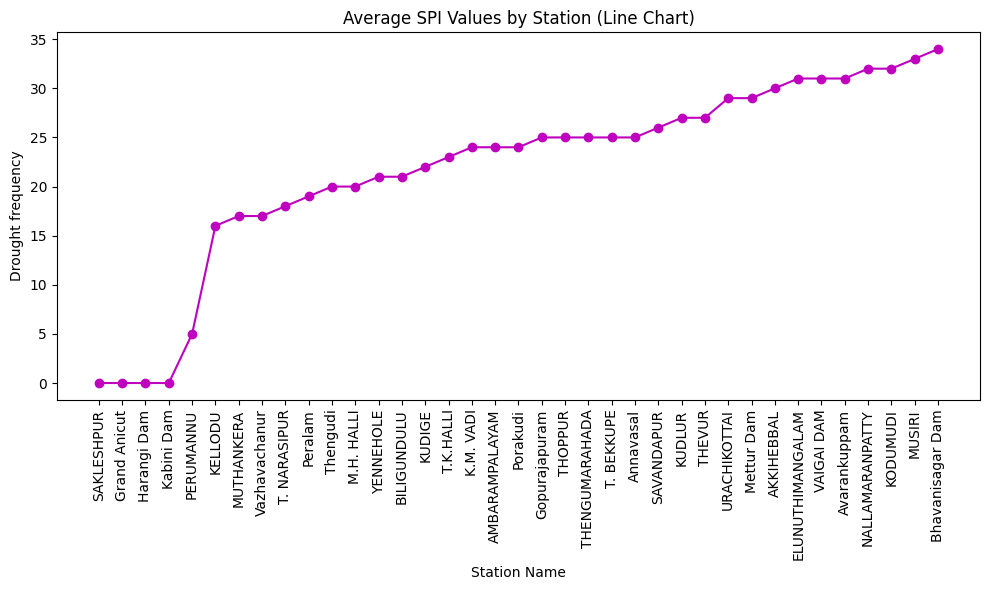

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('average_spi_values.csv')

# Ensure Station names are sorted (optional, based on your preference)
df = df.sort_values(by='Drought_Frequency')

# 1. Line Chart: SPI vs Station Name
plt.figure(figsize=(10, 6))
plt.plot(df['Station_Name'], df['Drought_Frequency'], marker='o', linestyle='-', color='m')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('Station Name')
plt.ylabel('Drought frequency')
plt.title('Average SPI Values by Station (Line Chart)')
plt.tight_layout()
plt.show()

